In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install foolbox
import foolbox 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim
import math

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached foolbox-3.3.1.tar.gz (1.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python /usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpCtQ7eT
       cwd: /tmp/pip-install-lRZ90P/foolbox
  Complete output (18 lines):
  Traceback (most recent call last):
    File "/usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py", line 280, i

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1=torch.device('cpu')
print(device)

cuda


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4845, 0.4903, 0.4508],[0.2135, 0.1970, 0.1911])
])

In [16]:
train_set=torchvision.datasets.ImageFolder(root="/home/ar_1/ucm_train/", transform=transformer)
valid_set=torchvision.datasets.ImageFolder(root="/home/ar_1/ucm_valid/", transform=transformer)

batch_size_train=4
batch_size_valid=4
train_loader=DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size_valid, shuffle=True)

In [6]:
class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 21,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

def densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)

In [7]:
model=densenet121().to(device)

In [8]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion=nn.CrossEntropyLoss()

In [9]:
train_count=len(train_set)
valid_count=len(valid_set)

In [ ]:
#best_accuracy=0.0
num_epochs=100

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    valid_loss=0.0
    valid_accuracy=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    model.eval()
    
    for data, target in valid_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
        
      # update-average-validation-loss 
      valid_loss += loss.item() * data.size(0)

      _,prediction=torch.max(output.data,1)
      valid_accuracy+=int(torch.sum(prediction==target.data))
      
    
    valid_accuracy=valid_accuracy/valid_count
    valid_loss=valid_loss/valid_count
       
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Valid Loss:'+str(valid_loss)+' Valid Accuracy:'+str(valid_accuracy))

    if(valid_accuracy>best_accuracy):
      torch.save(model.state_dict(), "/home/ar_1/weight/densenet.pth")
      best_accuracy=valid_accuracy
      print("Best accuracy: ", best_accuracy)


In [10]:
model.load_state_dict(torch.load("/home/ar_1/weight/densenet.pth"))

<All keys matched successfully>

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Test Accuracy of the model: {} '.format(correct / total))


Test Accuracy of the model: 0.801909307875895 


In [11]:
model=model.eval()

In [12]:
bounds = (0, 1)
fmodel = foolbox.PyTorchModel(model, bounds=bounds)

In [13]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
dir="/home/ar_1/ucm_train/"
classes = os.listdir(dir)
classes.sort()

0.9689737465232611


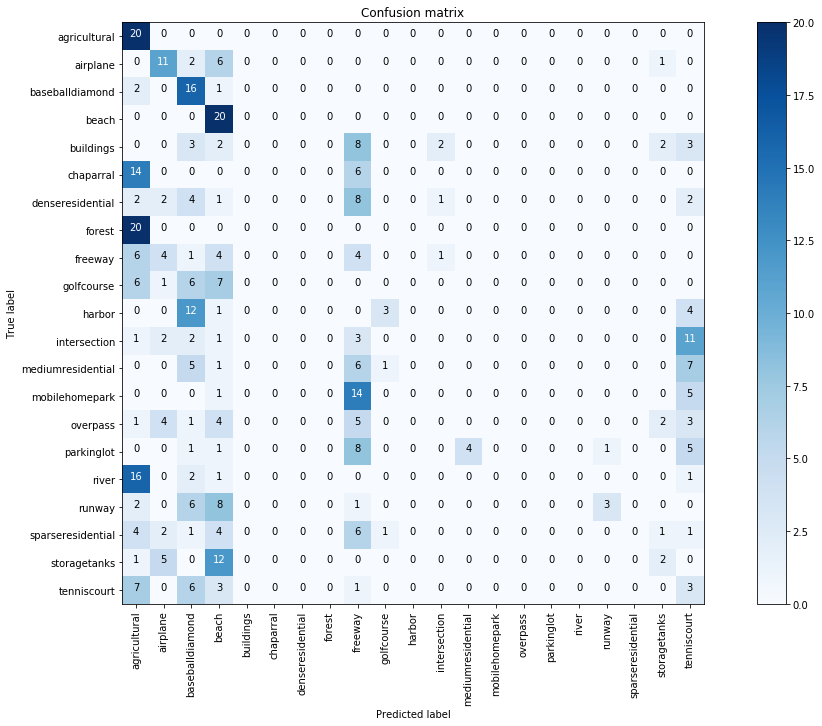

In [36]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ContrastReductionAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9737470149993896


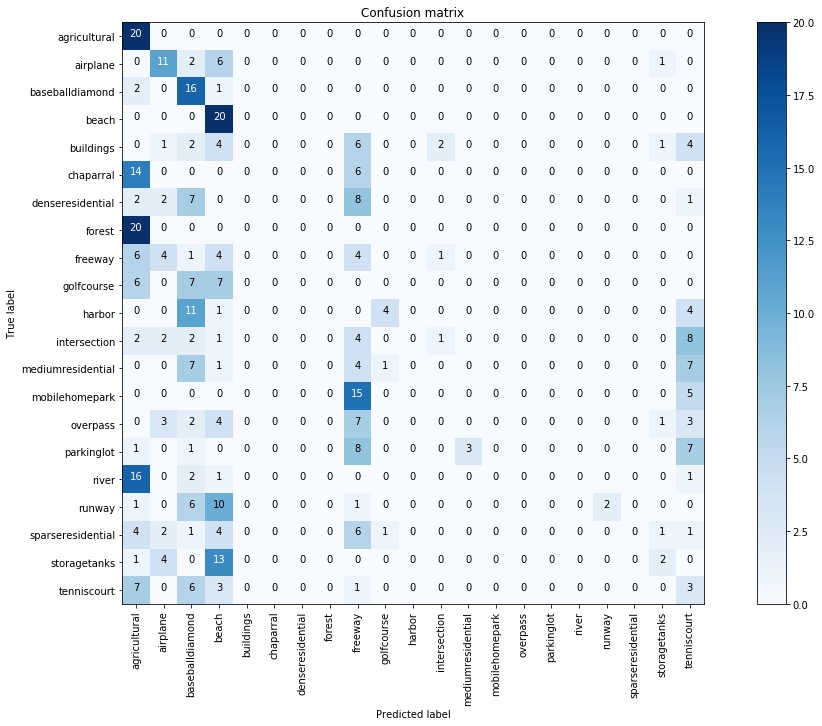

In [37]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.VirtualAdversarialAttack(steps=1)

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9737470149993896


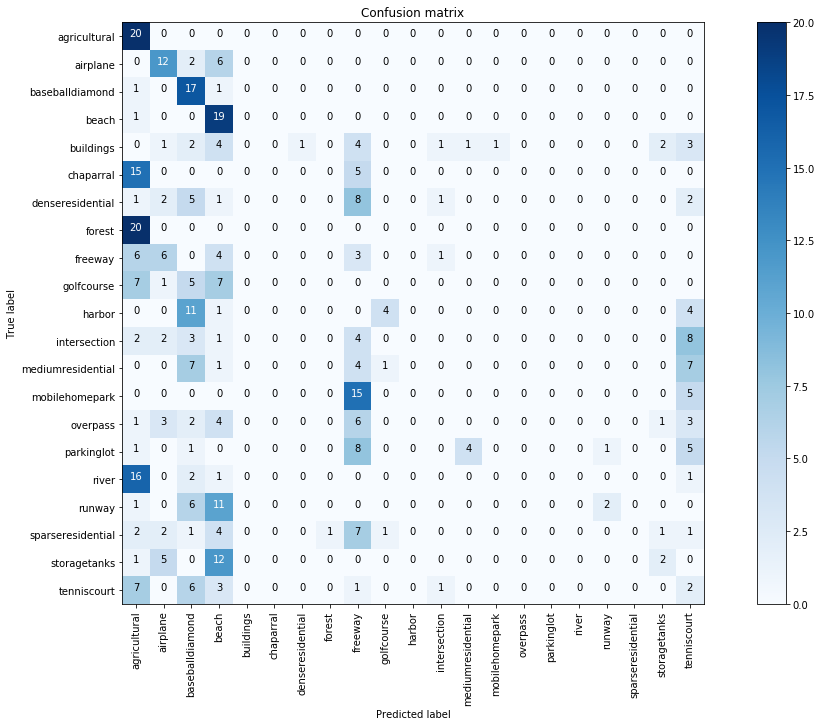

In [38]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.DDNAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9737470149993896


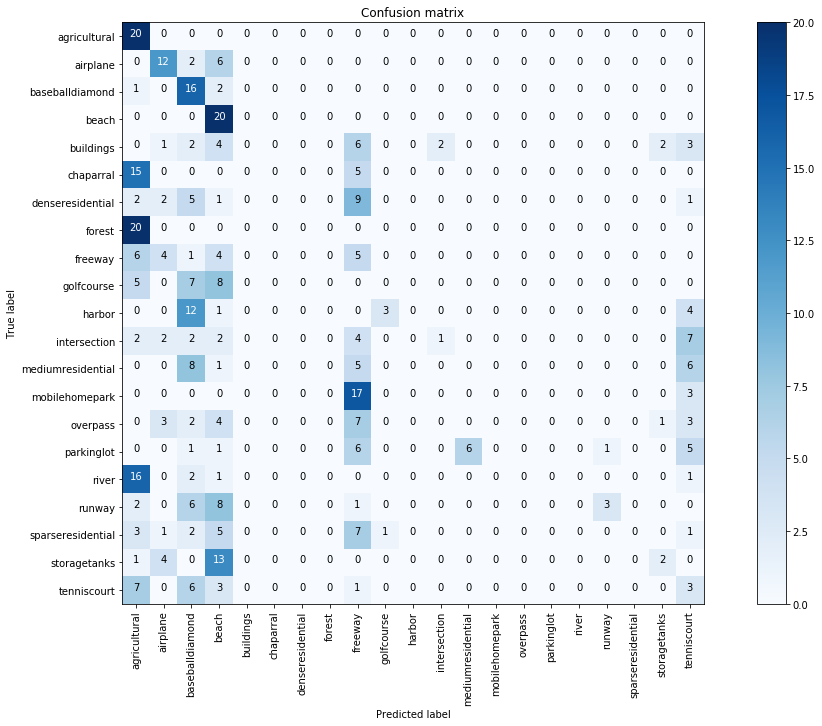

In [39]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.04057276248931885


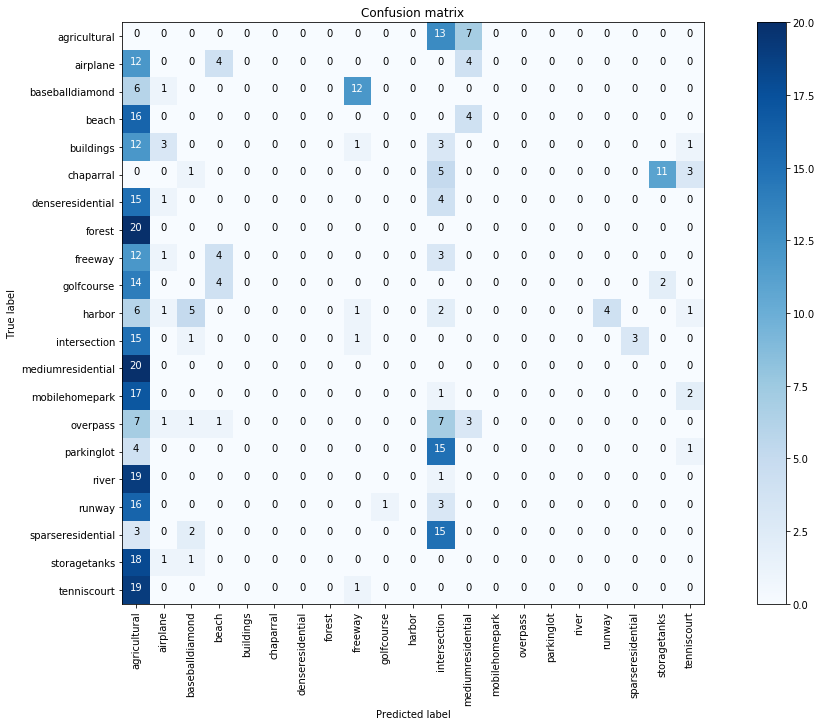

In [40]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9737470149993896


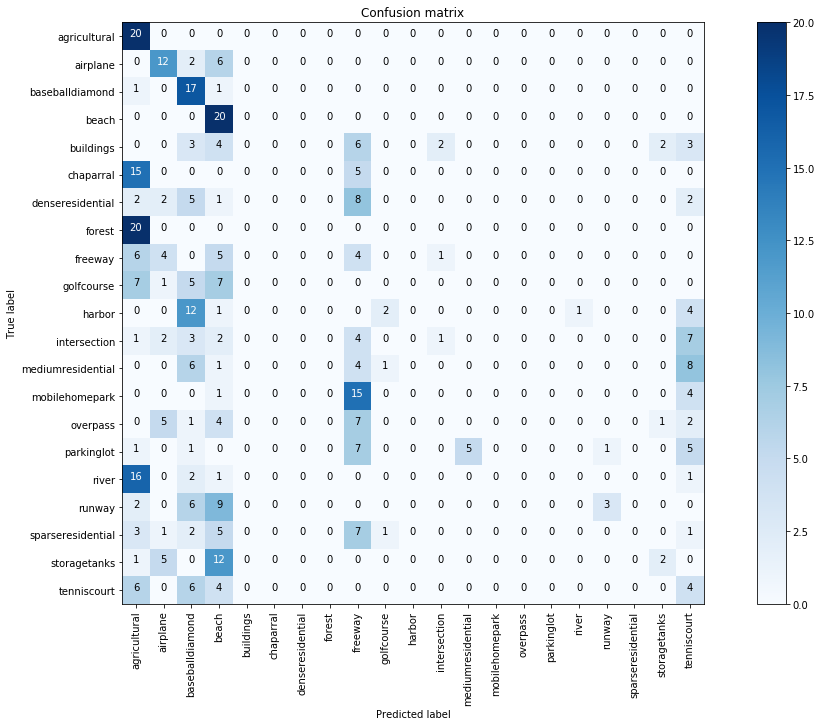

In [41]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2BasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.028639554977416992


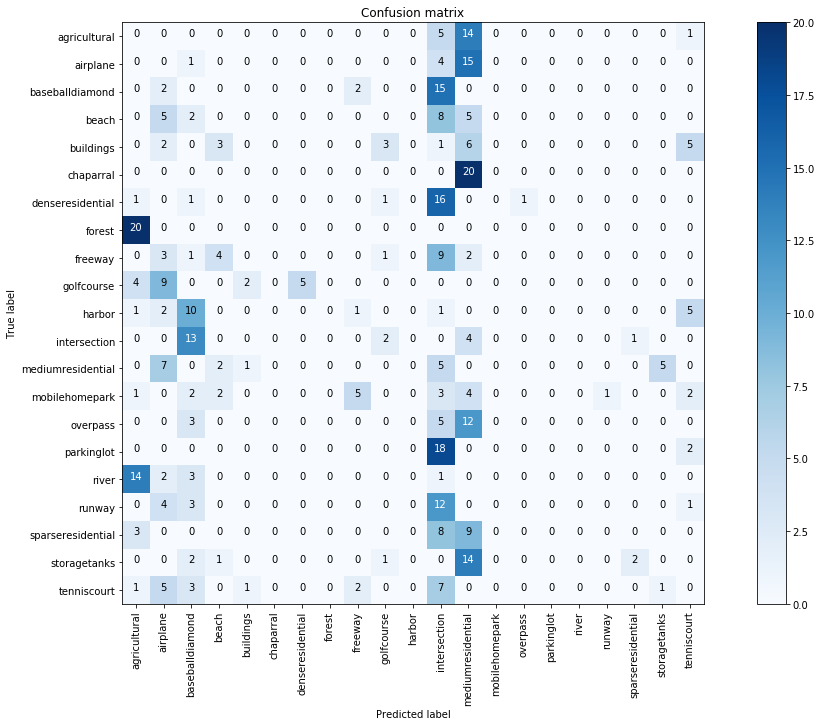

In [42]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfBasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9713603816926479


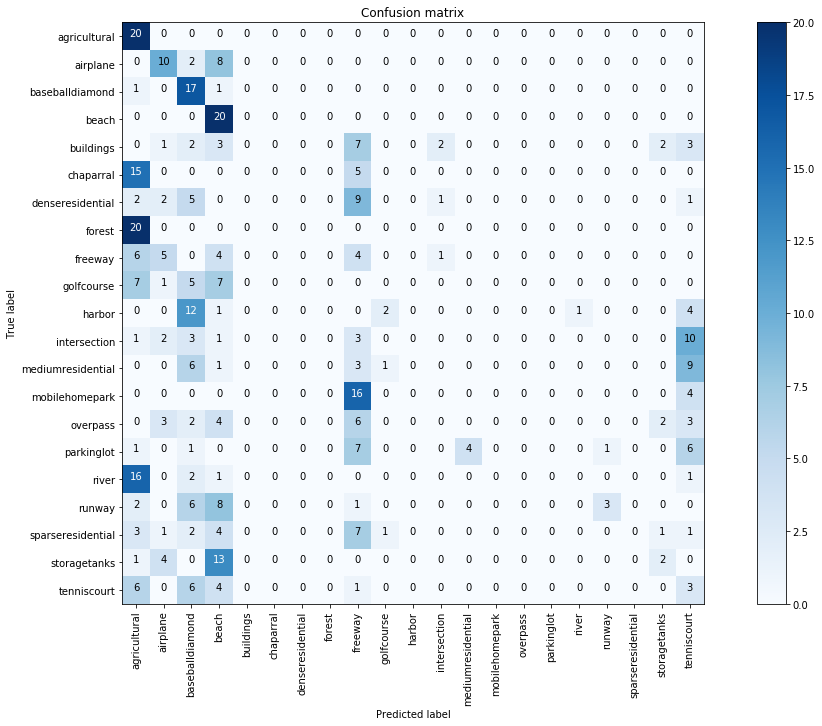

In [43]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2FastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.04534602165222168


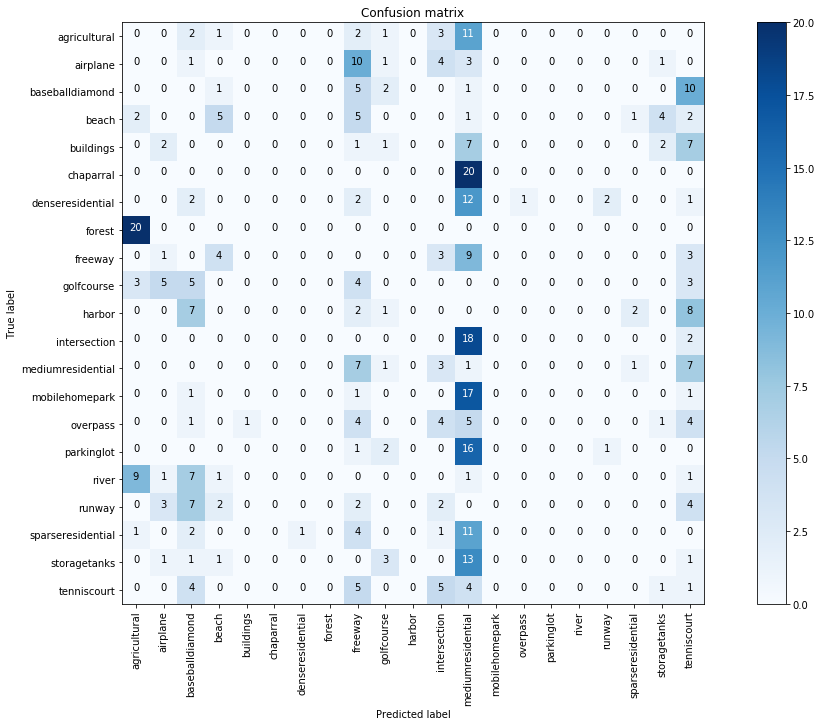

In [44]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfFastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9737470149993896


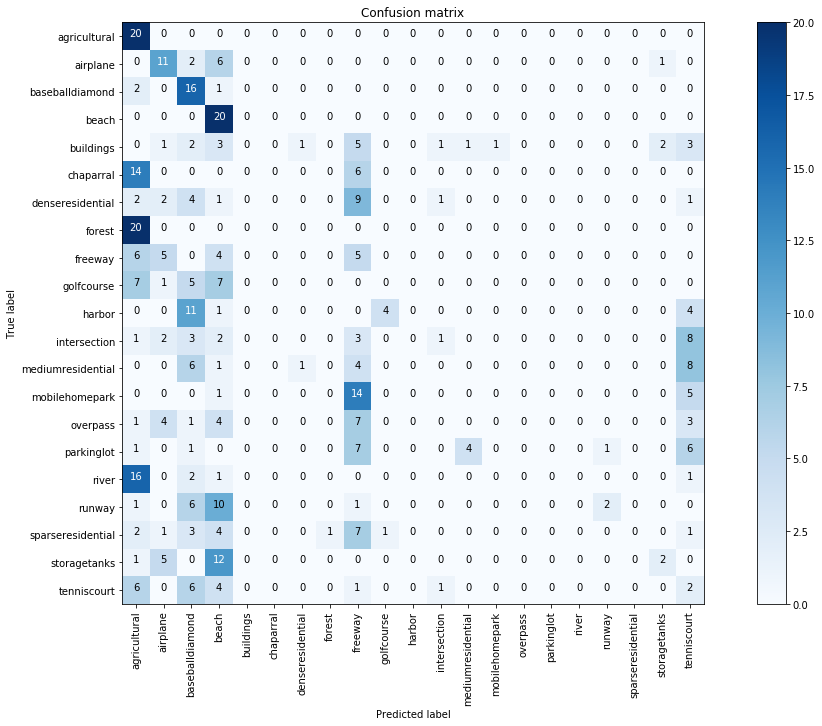

In [45]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9689737465232611


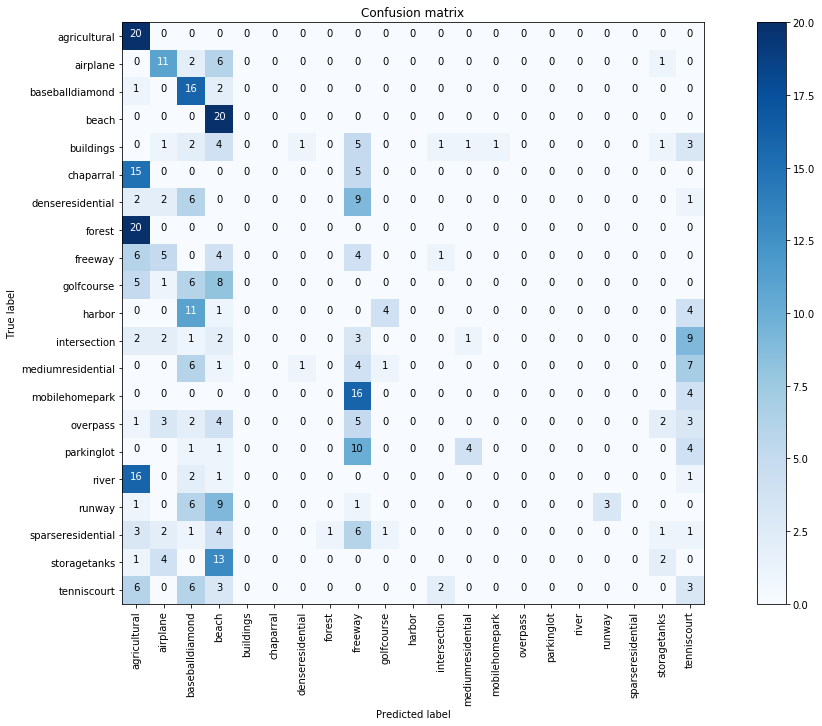

In [47]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1.0)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9713603816926479


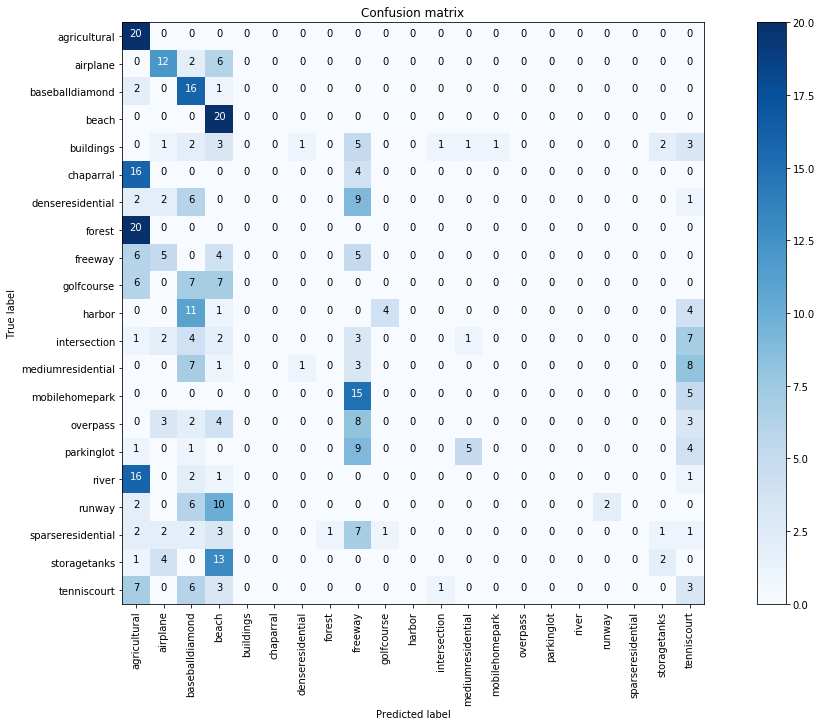

In [48]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9761336501687765


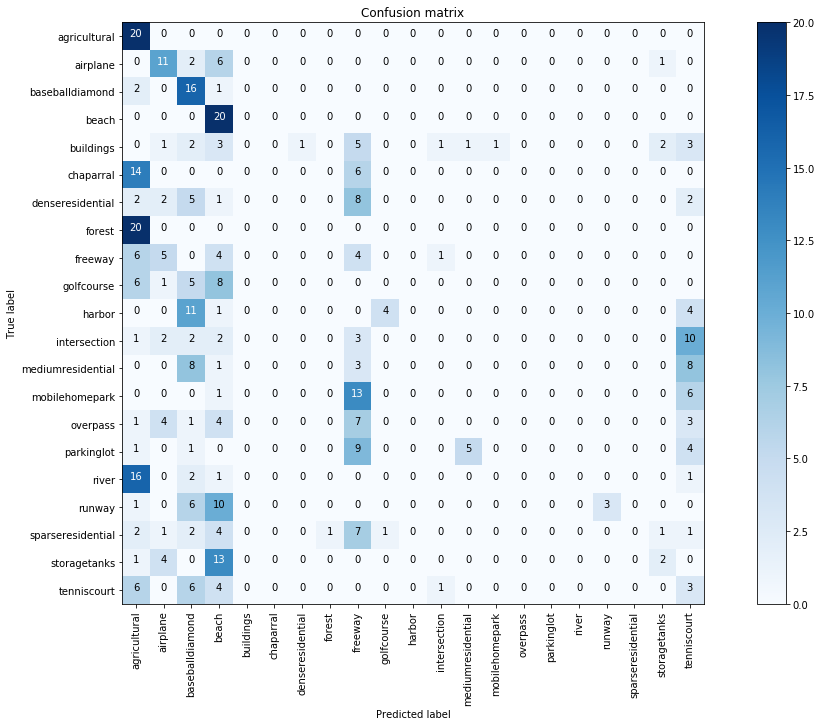

In [49]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.26491641998291016


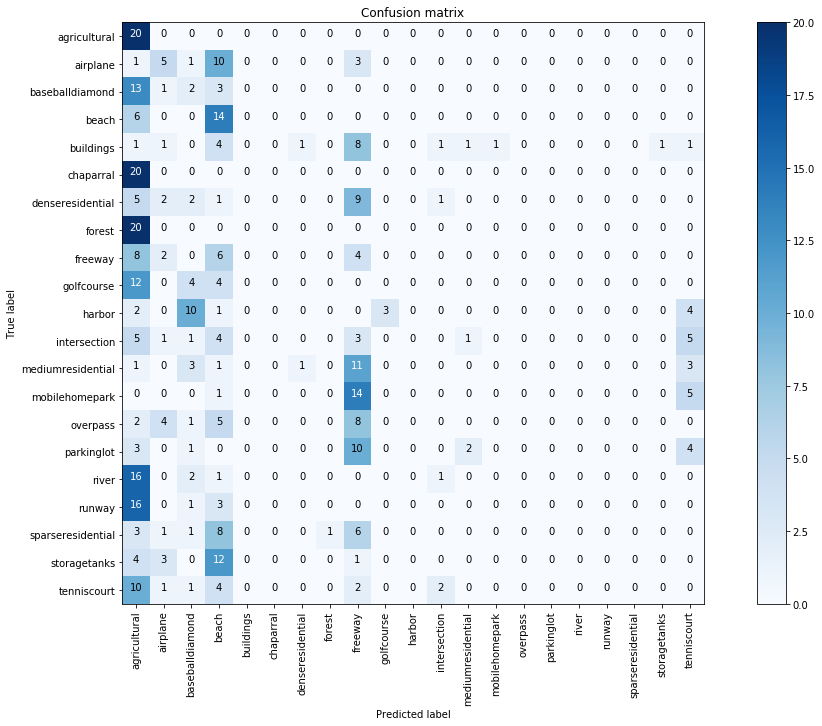

In [50]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9570405706763268


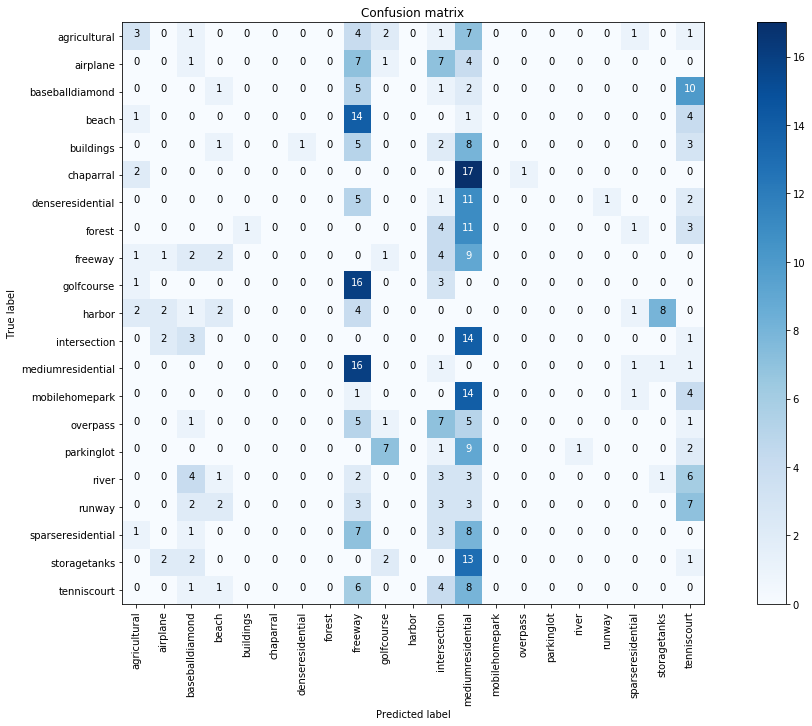

In [51]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.NewtonFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.24582338333129883


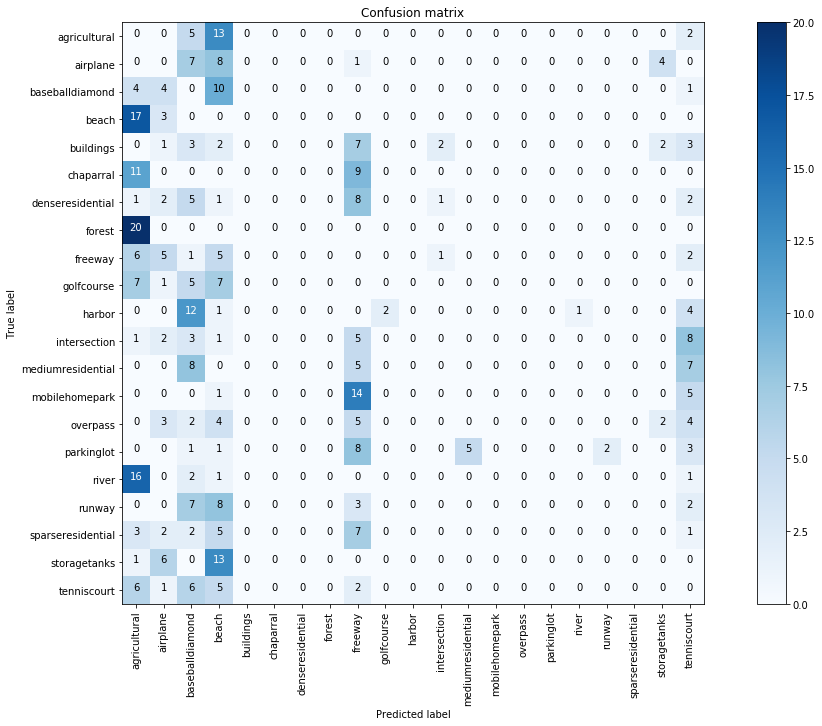

In [52]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfDeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9713603816926479


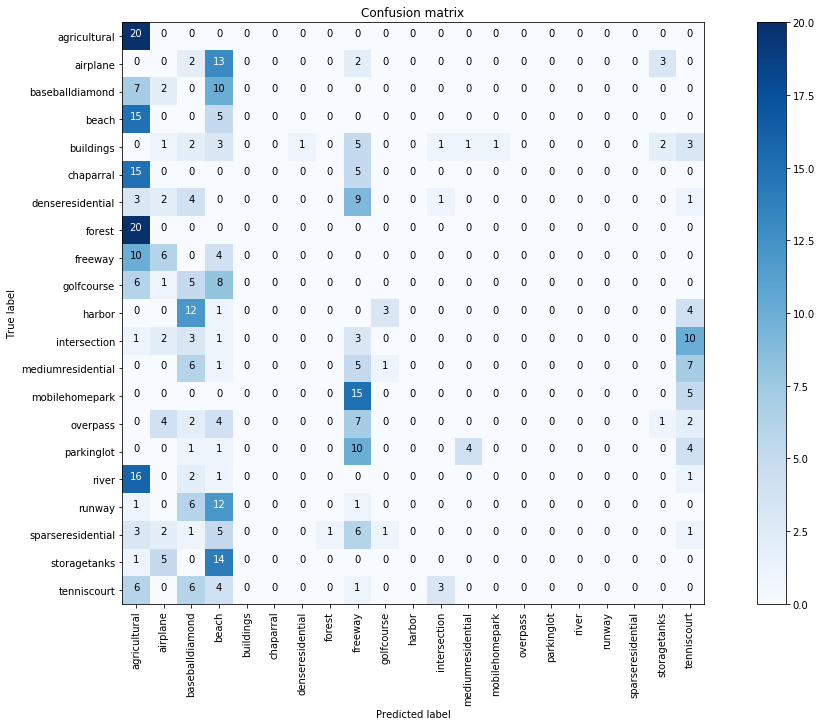

In [53]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.SaltAndPepperNoiseAttack()  

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9665871113538742


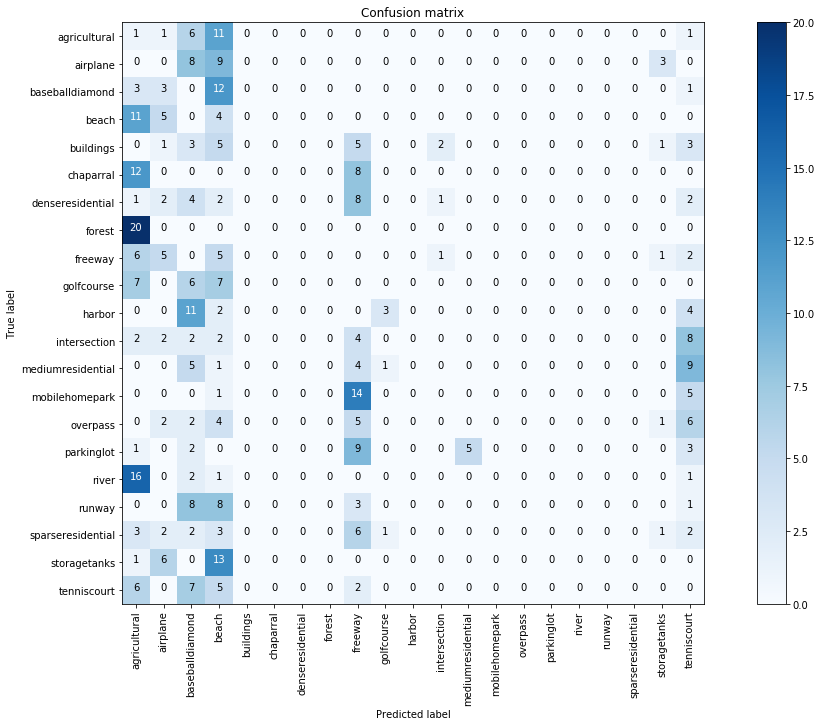

In [17]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2DeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.9713603816926479


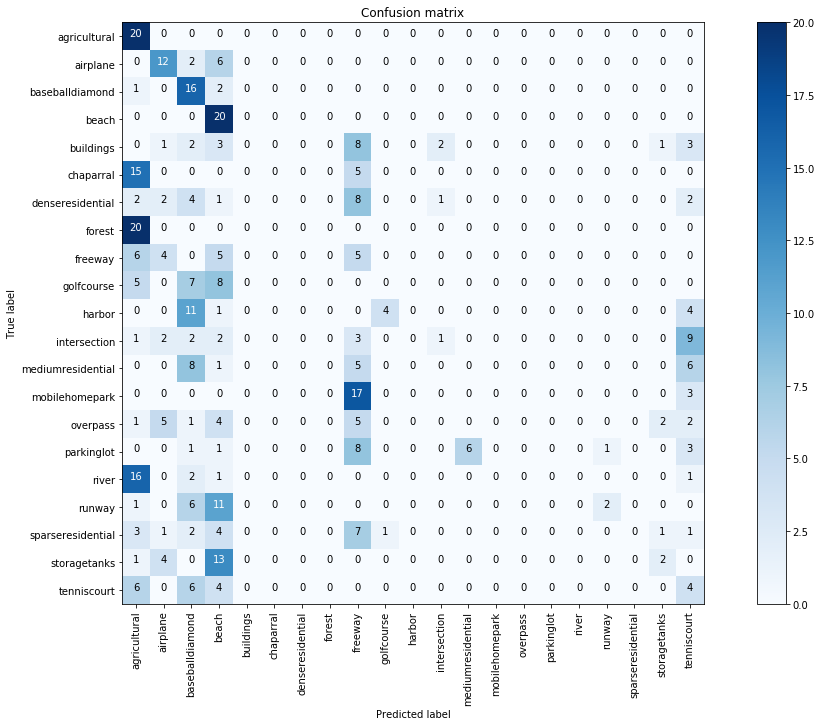

In [18]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9713603816926479


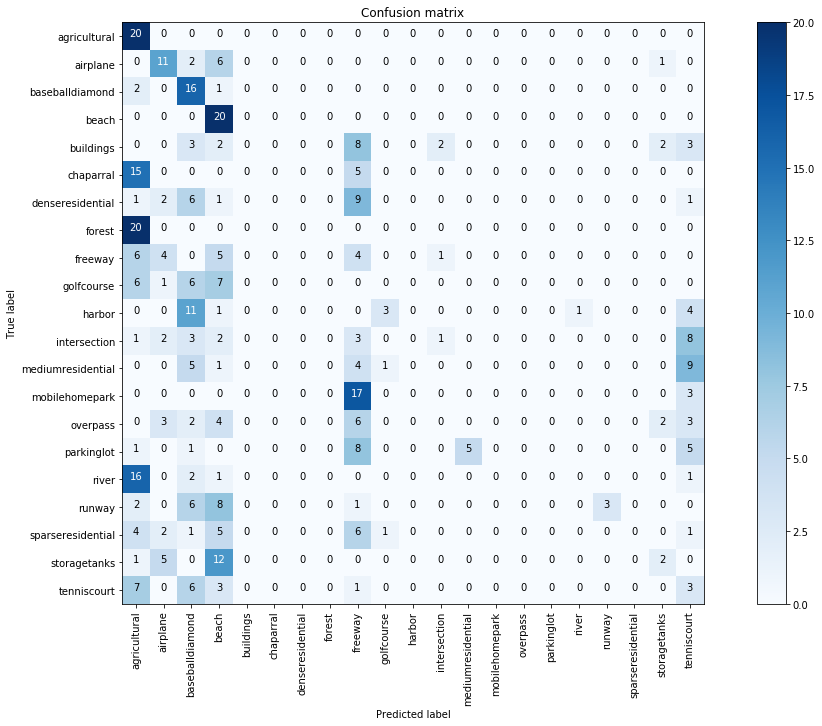

In [19]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9689737465232611


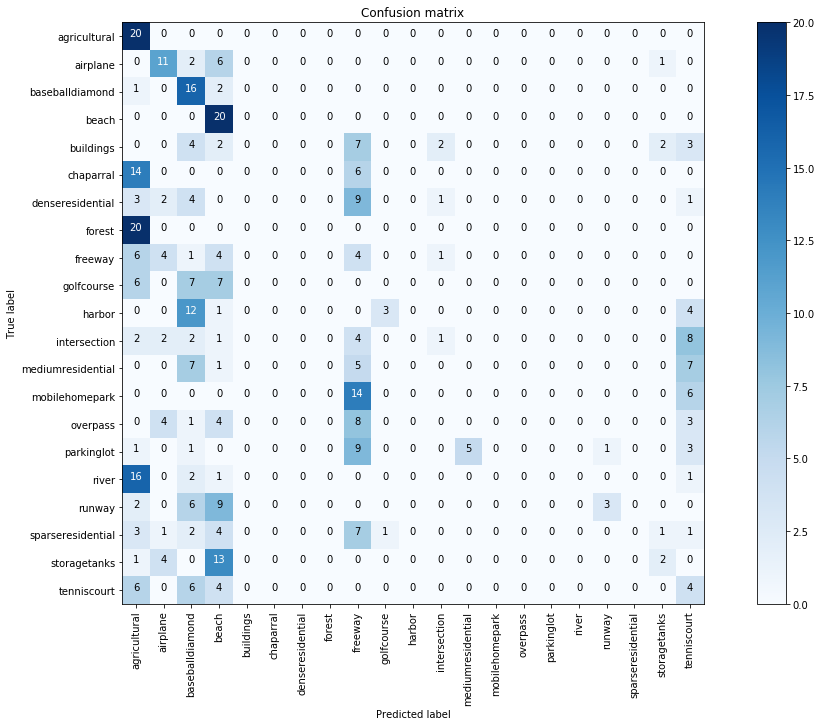

In [20]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9737470149993896


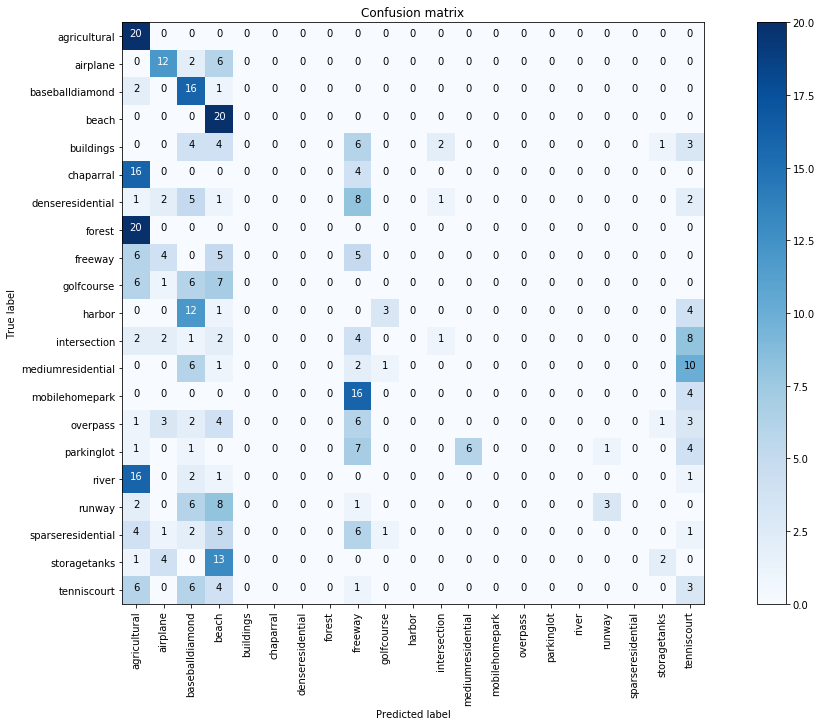

In [21]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.28400951623916626


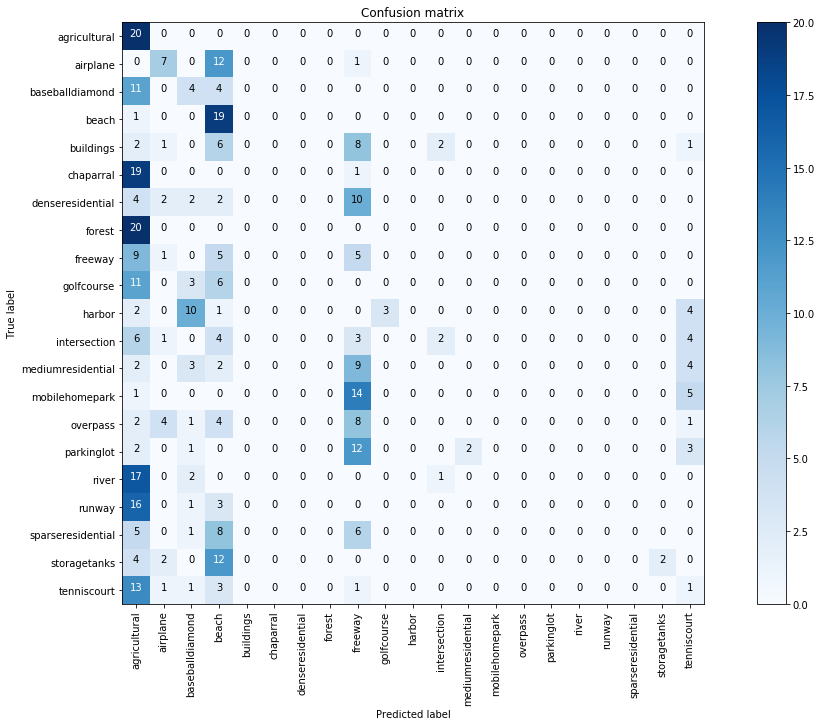

In [22]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9737470149993896


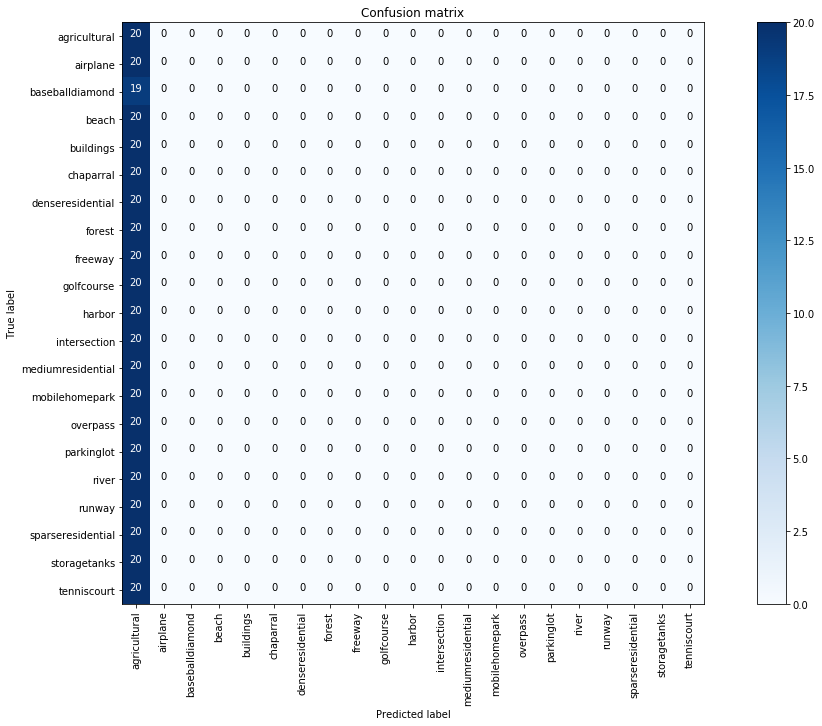

In [23]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2CarliniWagnerAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9689737465232611


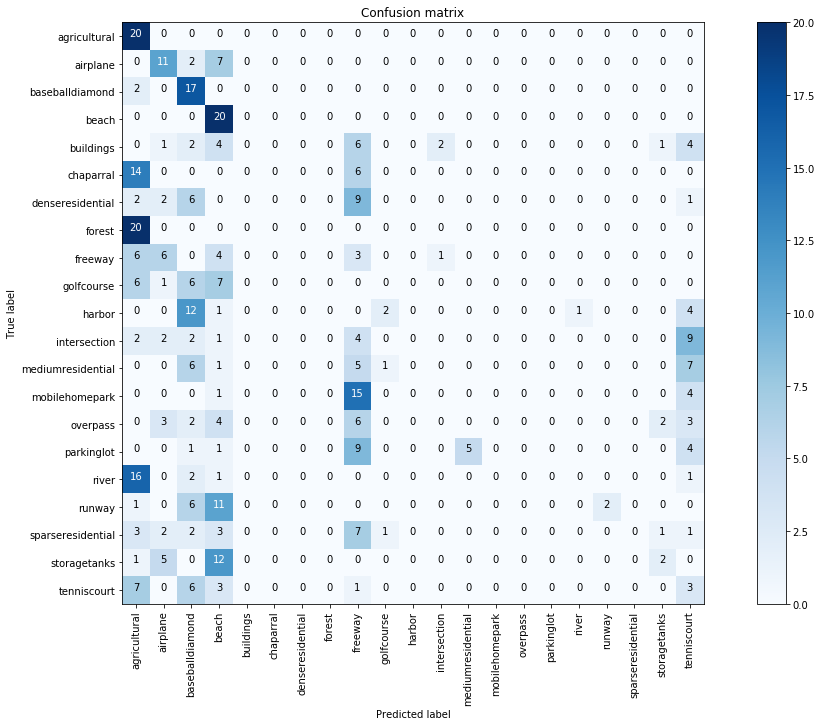

In [24]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.047732651233673096


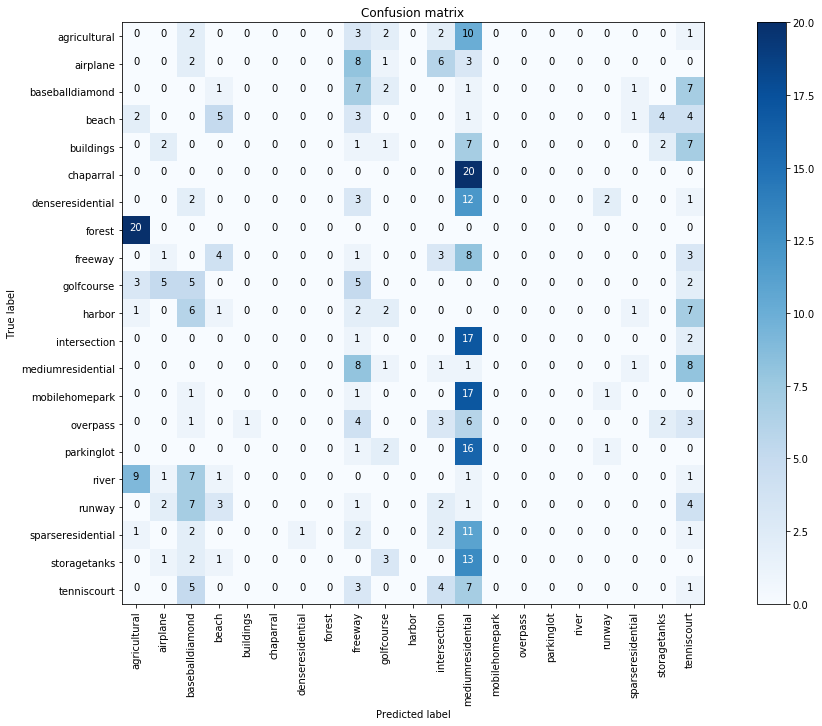

In [25]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGSM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.9737470149993896


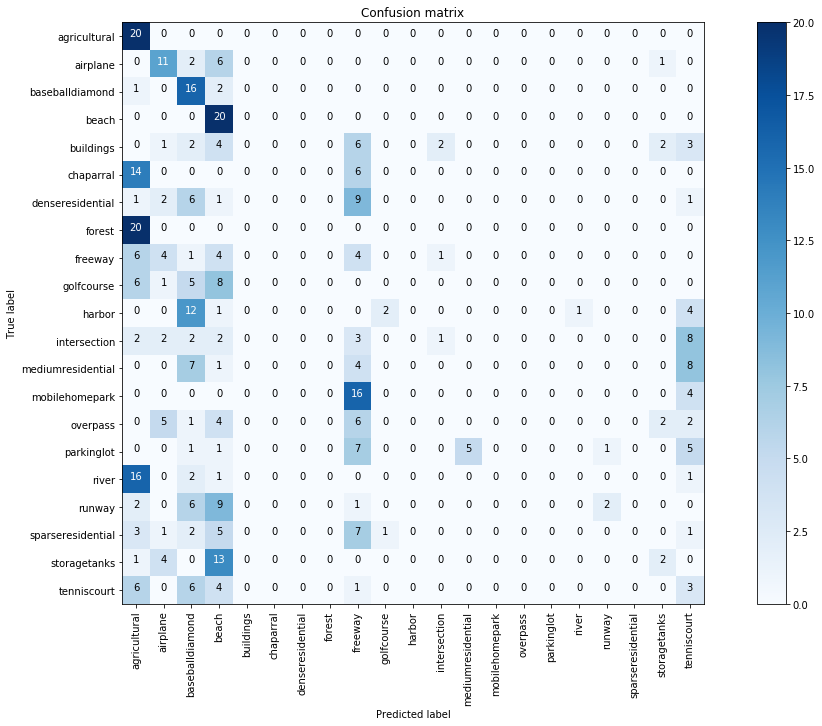

In [26]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2PGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.03818613290786743


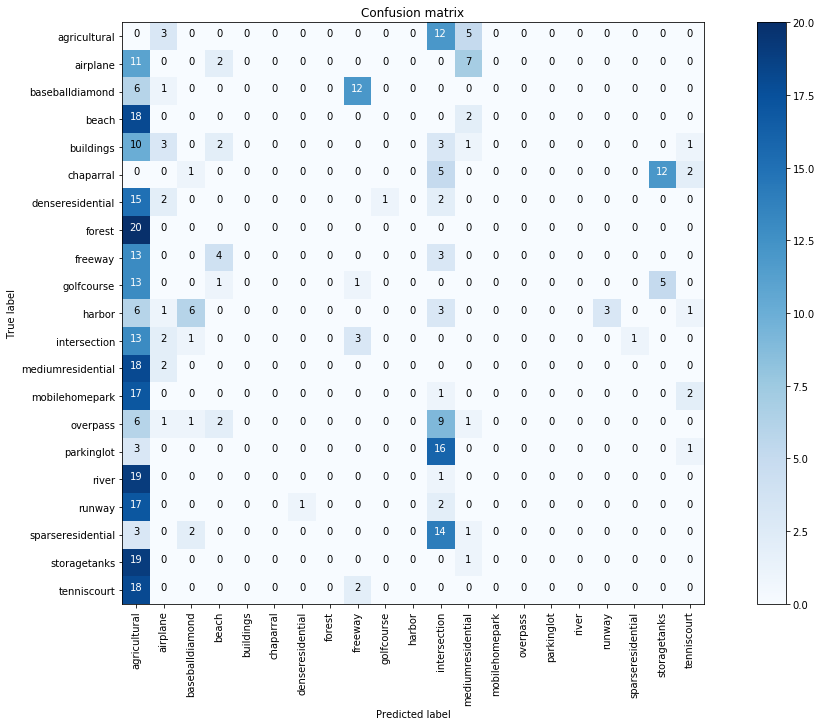

In [27]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfPGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.0334128737449646


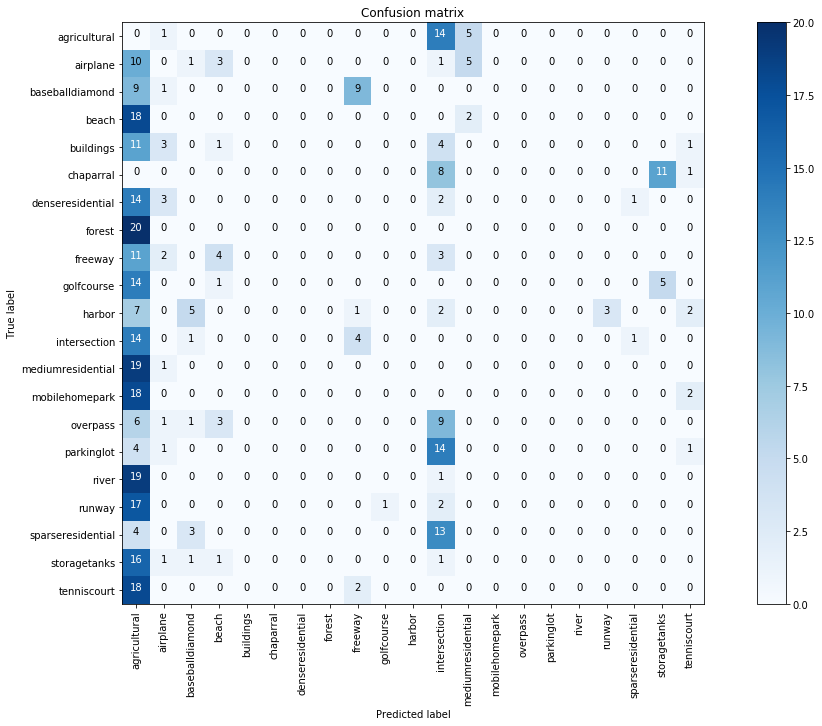

In [28]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.PGD()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)